# 1. Vector Space Model of Word Meaning

The goal of this problem set is to make you familiar with vector space model of word meaning. You may reuse some of functions you coded in Assignment 1. 

### Warning: This assignment may take substantial time to run if you are not optimizing your code. Make sure you have plenty of time to run if you are new to programming.

Go to https://drive.google.com/drive/folders/1Pe6D713L9S0GWwb_XzeLXAeNZOrBqZaN?usp=sharing and click add shortcut to drive. This will add the data required for this problem set to your Google drive.

<img src="https://drive.google.com/uc?id=1LqHisiziX8Ri94Xs6Cv8mhx6vivFM3kS" alt="Drawing" height="300"/>

Caution: Since this is real language on Twitter and deals with current events, some of it could be disturbing. In the later section of the course, we will deal with ethics and what is appropriate and what is not. 



Run the below code snippet. It will generate a URL which generates an authorization code.* Enter it below to give Colab access to your Google drive. 

*Copy function may not work. If so, manually copy the authorization code.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


When you run the `ls` command below, you should see the files in the tweets folder.




In [3]:
!ls "/content/drive/My Drive/tweets"

20000_tweets.jsonl
20000_tweets.txt
covid-tweets-2020-08-10-2020-08-21.tokenized.txt
covid-tweets-2020-08-10-2020-08-21.trigrams.txt
GoogleNews-vectors-negative300.bin.gz
stop_words.txt


In [62]:
# let's read tweets. These tweets are already tokenized and cleaned (Assignment 1)
tweets = open("/content/drive/My Drive/tweets/covid-tweets-2020-08-10-2020-08-21.tokenized.txt", "r").read().split("\n")
tweets = [tweet.split() for tweet in tweets]

print(len(tweets))


312878


## Problem 1.1: Word space model

Compute the most important context words of `ventilator`. Use Pointwise Mutual Information (PMI) to rank the context words (Refer to Lecture 4).

We define context as up to 3 words to the left and 3 words to the right. Ignore stop words and words that do not start with [a-z#]. Also ignore words that are not in the top 1000 frequent words.

These context words define the dimensions of the vector space model. Represent each word as a vector (dictionary/counter) of context words with PMI as the importance of the context word. Print the top 20 context words for each.

This is the sample output I got for `ventilator`. Your numbers need not match mine but the ranked list should look close to what I have.

```
[('put', 18.280538283196606), ('wearing', 17.587373569812726), ('even', 17.58651933524197), ('like', 17.402738298715878), ('covid', 17.172590097063086), ('patients', 16.894419647496004), ('use', 16.894298589380956), ('die', 16.89426559608771), ('days', 16.89415252713107), ('needed', 16.489137134110106), ('month', 16.48907033839664), ('weeks', 16.488913820220848), ('away', 16.48879303327717), ('week', 16.488739054051933), ('person', 16.488678720881293), ('good', 16.488160838026904), ('deaths', 16.487822204799755), ('go', 16.487564042558112), ('would', 16.48707075078768), ('one', 16.48706217686235), ('get', 16.486565870239033)]
```



Let's first load stop words.

In [63]:
stop_words = set()
def load_stop_words():
  words = open("/content/drive/My Drive/tweets/stop_words.txt", "r").read().split("\n")
  for word in words:
    stop_words.add(word.strip())

load_stop_words()
print(len(stop_words))

134


In [64]:
import collections
import math
import re

def precompute():
    # remove stop words
    no_stops_tweets = [[token for token in tweet if token not in stop_words] for tweet in tweets]

    # remove non [a-z#] tokens
    alpha_tweets = [[token for token in tweet if re.match('^[a-z#]', token)] for tweet in no_stops_tweets]

    # count word frequencies
    counter = collections.Counter()
    N = 0
    for tweet in alpha_tweets:
        N += len(tweet)
        counter.update(tweet)

    all_word_counts = dict(counter)
    top_words = set([word for word, freq in counter.most_common(1000)])

    max_context = 3
    coloc_counter = collections.defaultdict(int)
    for tweet in alpha_tweets:
        for idx in range(len(tweet)):
            # going backwards starting from word behind central word
            off = -1
            back_context = 0
            # search until we hit end of tweet or we have collected the max number of context word behind the word i.e. 3
            while idx + off >= 0 and back_context < max_context:
                # making sure we only include top 1000 words
                if tweet[idx + off] in top_words:
                    coloc_counter[(tweet[idx], tweet[idx + off])] += 1
                    back_context += 1
                off -= 1

            # going forwards starting from word ahead of central word
            off = 1
            forward_context = 0
            while idx + off < len(tweet) and forward_context < max_context:
                if tweet[idx + off] in top_words:
                    coloc_counter[(tweet[idx], tweet[idx + off])] += 1
                    forward_context += 1
                off += 1

    data = { "N": N,  "top_words": top_words, "all_word_counts": all_word_counts, "coloc": coloc_counter, "alpha_tweets": alpha_tweets }
    return data

data = precompute()

Let's build the word vectors

In [66]:
def PMI(word1, word2):
  # You have to store frequencies of individual words and (word, context word) 
  # pairs to compute this. You can compute them beforehand in order to avoid 
  # counting every time when this function is called.
  # Write your code

  if data["coloc"][(word1, word2)] == 0:
      return 0

  return math.log((data["coloc"][(word1, word2)] * data["N"]) / (data["all_word_counts"][word1] * data["all_word_counts"][word2]))

def build_word_vector(word):
    # Write your code
    top_words = data["top_words"]
    return [(top_word, PMI(word, top_word)) for top_word in top_words]

def print_top_dimensions(word_vector, n):
  # print top n dimensions sorted in the order of importance.
  return sorted(word_vector, key=lambda t: t[1], reverse=True)[:n]

v1 = build_word_vector('ventilator')
print_top_dimensions(v1, 20) # print top 20 dimensions along with their weights


[('patient', 5.566000919612041),
 ('hospital', 4.943994839077336),
 ('patients', 4.754752839438807),
 ('put', 4.591270340211511),
 ('brain', 4.567622691910836),
 ('spent', 4.318976847785691),
 ('blood', 4.30327345585724),
 ('enjoy', 4.282249556065533),
 ('tried', 4.268475233600704),
 ('loved', 4.217797723844838),
 ('end', 4.202171285881991),
 ('nearly', 4.152365583898054),
 ('days', 4.126892766336076),
 ('critical', 4.121187998698428),
 ('increase', 4.100737388227137),
 ('needed', 4.042872328676352),
 ('month', 4.028779954536644),
 ('experience', 4.00853419109546),
 ('yesterday', 4.005374630805092),
 ('weeks', 3.9578036429242243)]

## Problem 1.2: Compute the word similarity between words using Cosine Similarity.

Compute cosine similarity between the following pair of words: 
```
('ventilator', 'covid-19')
('ventilator', 'lockdown')
('ventilator', 'mask')
('ventilator', 'ppe')
```

Outputs of my code are:
```
('ventilator', 'covid-19') 0.17076006036635358
('ventilator', 'lockdown') ...
('ventilator', 'mask') 0.19229601085517933
('ventilator', 'ppe') ...
```


In [67]:
def cosine_similarity(vector1, vector2):
  # write your code
  assert len(vector1) == len(vector2)
  xy = 0
  x2 = 0
  y2 = 0
  for idx in range(len(vector1)):
      xy += vector1[idx][1] * vector2[idx][1]
      x2 += vector1[idx][1] ** 2
      y2 += vector2[idx][1] ** 2

  return xy / (math.sqrt(x2) * math.sqrt(y2))

ventilator = build_word_vector('ventilator')
covid19 = build_word_vector('covid-19')
lockdown = build_word_vector('lockdown')
mask = build_word_vector('mask')
ppe = build_word_vector('ppe')

print(('ventilator', 'covid-19'), cosine_similarity(ventilator, covid19))
print(('ventilator', 'lockdown'), cosine_similarity(ventilator, lockdown))
print(('ventilator', 'mask'), cosine_similarity(ventilator, mask))
print(('ventilator', 'ppe'), cosine_similarity(ventilator, ppe))

('ventilator', 'covid-19') 0.5144748736474375
('ventilator', 'lockdown') 0.49838268423693
('ventilator', 'mask') 0.46080412510653646
('ventilator', 'ppe') 0.4465612497957502


## Problem 1.3: What can you tell about these words from the similarities?

1. `ventilator` when compared with `covid-19, lockdown, mask, ppe`
2. `pandemic` when compared with `covid-19, lockdown, mask, ppe`
3. `president` compared with `trump, biden`
4. `trudeau` compared with `trump, biden`



In [69]:
print(('pandemic', 'covid-19'), cosine_similarity(ventilator, covid19))
print(('pandemic', 'lockdown'), cosine_similarity(ventilator, lockdown))
print(('pandemic', 'mask'), cosine_similarity(ventilator, mask))
print(('pandemic', 'ppe'), cosine_similarity(ventilator, ppe))
print('')
print(('president', 'trump'), cosine_similarity(ventilator, covid19))
print(('president', 'biden'), cosine_similarity(ventilator, lockdown))
print('')
print(('trudeau', 'trump'), cosine_similarity(ventilator, covid19))
print(('trudeau', 'biden'), cosine_similarity(ventilator, lockdown))

('pandemic', 'covid-19') 0.5144748736474375
('pandemic', 'lockdown') 0.49838268423693
('pandemic', 'mask') 0.46080412510653646
('pandemic', 'ppe') 0.4465612497957502

('president', 'trump') 0.5144748736474375
('president', 'biden') 0.49838268423693

('trudeau', 'trump') 0.5144748736474375
('trudeau', 'biden') 0.49838268423693


The word 'covid-19' is most associated with 'pandemic', and 'ppe' is least associated with 'pandemic', out of 'covid-19', 'lockdown', 'mask', and 'ppe'. The word 'trump' is more associated with 'president' than 'biden' is, this makes sense, as right now Trump has been president for more time than Biden. The word 'trump' is more associated with 'trudeau' than 'biden' is. This makes sense, as at this time Trudeau and Trump have been leaders together longer than Trudeau and Biden.

# Let's play with word2vec

First let's load word2vec. I am using [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) but feel free to use any libraries or tools.

In [2]:
from gensim.models import KeyedVectors

EMBEDDING_FILE = '/content/drive/My Drive/tweets/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

## Problem 1.4: Compute the top 5 similar words of `ventilator` using word2vec?

In [4]:
# Write your code here

similar_words = word2vec.similar_by_word("ventilator")
for idx in range(5):
    similar_key, _ = similar_words[idx]
    print(f"Ranking {idx + 1}: Word: {similar_key}")

Ranking 1: Word: respirator
Ranking 2: Word: mechanical_ventilator
Ranking 3: Word: intensive_care
Ranking 4: Word: ventilators
Ranking 5: Word: breathing_tube


# Problem 1.5: Word analogy

If I told you the plural of `car` is `cars`, can you automatically find the plural of `hypothesis` and `man` using word2vec.

Similarly, if I told you a newborn `dog` is called `puppy`, can you automatically find what are the newborn words of `cat` and `sheep` using word2vec?


In [6]:
# Write your code here
singular_words = ["hypothesis", "man"]
for singular_word in singular_words:
    result = word2vec.most_similar(positive=[singular_word, "cars"], negative=["car"])
    similar_word, _ = result[0]
    print(f"Plural of {singular_word} is {similar_word}")

adult_words = ["cat", "sheep"]
for adult_word in adult_words:
    result = word2vec.most_similar(positive=[adult_word, "puppy"], negative=["dog"])
    similar_word, _ = result[0]
    print(f"Newborn of {adult_word} is {similar_word}")

Plural of hypothesis is hypotheses
Plural of man is men
Newborn of cat is kitten
Newborn of sheep is lambs


# 2. Topic Models 

The goal of this part is to make you familiar with topic models. You may reuse some of functions you coded for the previous assignments.

## Data Download and Setup

Let us start by downloading the news section of the Brown corpus:

In [3]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
documents = [brown.words(fileid) for fileid in brown.fileids()]

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


Let us inspect some of the documents:

In [4]:
print("The news section of the Brown corpus contains {} documents.".format(len(documents)))
for i in range(3):
  document = documents[i]
  print("Document {} has {} words: {}".format(i, len(document), document))

The news section of the Brown corpus contains 500 documents.
Document 0 has 2242 words: ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]
Document 1 has 2277 words: ['Austin', ',', 'Texas', '--', 'Committee', 'approval', ...]
Document 2 has 2275 words: ['Several', 'defendants', 'in', 'the', 'Summerdale', ...]


Finally, let us download a list of stopwords for later.

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
print(stopwords_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

## Problem 2.1: Document-Term Matrix

Create a document-term matrix with tf-idf. You should preprocess documents by: 1) lowercasing words, 2) excluding stopwords, and 3) including alphanumeric strings only.

```python
import numpy as np
def create_tfidf_matrix(documents: List[List[str]]) -> (np.array, List[str]):
  # Args:
  #   documents: list of documents, each document being a list of words.
  # Outputs:
  #   tfidf_matrix: np.array of shape (num_documents, vocabulary_size)
  #   vocabulary: a list of terms corresponding to the columns of the matrix.

tfidf_matrix, vocabulary = create_tfidf_matrix(documents)
```

How sparse is this matrix? Calculate the ratio between cells with value 0 and the total number of cells. 


In [5]:
import collections
import math
import re
from typing import List

import numpy as np

def create_tfidf_matrix(documents: List[List[str]]) -> (np.array, List[str]):
    # Args:
    #   documents: list of documents, each document being a list of words.
    # Outputs:
    #   tfidf_matrix: np.array of shape (num_documents, vocabulary_size)
    #   vocabulary: a list of terms corresponding to the columns of the matrix.
    
    # clean documents by lowercasing, removing stopwords and including only alphanumeric terms
    processed_docs = [[token.lower() for token in doc if token.lower() not in stopwords_list and re.fullmatch('^[a-zA-Z0-9]*', token.lower())] for doc in documents]

    # get the set of unique words
    unique_words = set()
    for doc in processed_docs:
        for token in doc:
            unique_words.add(token)

    # get unique word indices
    idx = 0
    word_index = {}
    for word in unique_words:
        word_index[word] = idx
        idx += 1

    num_unique = len(unique_words)
    num_docs = len(processed_docs)

    # calculate tf
    tf = np.zeros((num_docs, num_unique))

    for doc_idx in range(len(processed_docs)):
        num_words = len(processed_docs[doc_idx])
        word_count = dict(collections.Counter(processed_docs[doc_idx]))
        for word, count in word_count.items():
            tf[doc_idx, word_index[word]] = count / num_words

    # calculate idf
    idf = np.zeros((1, num_unique))
    word_docs = collections.defaultdict(int)
    for doc in processed_docs:
        doc_set = set(doc)
        for word in doc_set:
            word_docs[word] += 1
    
    for word, word_idx in word_index.items():
        idf[0, word_idx] = math.log(num_docs / word_docs[word])

    # create ordered list of vocab
    vocab = [''] * num_unique
    for word, idx in word_index.items():
        vocab[idx] = word

    return tf * idf, vocab



tfidf_matrix, vocabulary = create_tfidf_matrix(documents)

sparsity = np.count_nonzero(tfidf_matrix==0) / tfidf_matrix.size
print(f"Sparsity: {sparsity}")

Sparsity: 0.9845266994447298


## Problem 2.2: Latent Semantic Analysis

We perform LSA to obtain document embeddings `U` and term embeddings `VT`.

```python
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(tfidf_matrix, 
                              n_components=10,
                              n_iter=100,
                              random_state=42)
```

Define a function to find the 5 most relevant terms for each of the 10 latent dimensions (tip: you should make use of VT and the vocabulary).

```python
def extract_salient_words(VT: np.array, 
                  vocabulary: List[str]
                  ) -> salient_words: dict[int, List[str]]:
  # Args:
  #  VT: a numpy array of size (n_components, vocabulary_size)
  #  vocabulary: a list of words of size vocabulary_size
  # Outputs:
  #  salient_words: a dictionary with the latent dimension indices as keys and a list of its 5 most salient words as values

salient_words = extract_salient_words(VT, vocabulary)

for key, value in salient_words:
  print("Concept {}: {}".format(str(key), " ".join(value)))
```

In [9]:
import collections
from typing import Dict

from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(tfidf_matrix, 
                              n_components=10,
                              n_iter=100,
                              random_state=42)

def extract_salient_words(VT: np.array, 
                  vocabulary: List[str]
                  ) -> Dict[int, List[str]]:
    # Args:
    #  VT: a numpy array of size (n_components, vocabulary_size)
    #  vocabulary: a list of words of size vocabulary_size
    # Outputs:
    #  salient_words: a dictionary with the latent dimension indices as keys and a list of its 5 most salient words as values

    top_num = 5
    salient_words = collections.defaultdict(list)
    for dim_idx in range(VT.shape[0]):
        lat_dim = VT[dim_idx, :]
        top_word_indices = lat_dim.argsort()[-top_num:][::-1]
        for word_idx in top_word_indices:
            salient_words[dim_idx].append(vocabulary[word_idx])

    return salient_words


salient_words = extract_salient_words(VT, vocabulary)

for key, value in salient_words.items():
  print("Concept {}: {}".format(str(key), " ".join(value)))

Concept 0: af polynomial operator theorem q
Concept 1: af polynomial operator theorem diagonalizable
Concept 2: anode holder arc temperature plug
Concept 3: anode phil mike deegan jess
Concept 4: staining nonspecific clover sections wtv
Concept 5: dictionary text cell platform information
Concept 6: platform gyro accelerometer leveling axis
Concept 7: q tangent secants c curve
Concept 8: feed phil milligrams cattle grams
Concept 9: phil mike deegan eddie anniston


## Problem 2.3: Document Retrieval

Given a text query, view this as a mini document, and compare it to your documents in the low-dimensional space.

First, we need to create a vector $\mathbf{d}$, which is the tf-idf representation of the query. Then we project it into the semantic space with the linear map $\Sigma^{-1} V^\top$ learned above. This gives us a pseudo-document embedding $\hat{\mathbf{d}}$.

$$\hat{\mathbf{d}} = \Sigma^{-1} V^\top \mathbf{d}$$

Then, you will need to implement a function to calculate the cosine similarity between this embedded query and all the document embeddings.

Retrieve the indices of the top-3 documents with the highest cosine similarity with the following queries:


```python
query1 = ['T.', 'V.', 'Barker', 'developed', 'the', 'classification-angle', 'system']
query2 = ['imitation', 'vs.', 'formalism' 'in', 'philosophical', 'debates']
query3 = ['Krim', 'attended', 'the', 'University', 'of', 'North', 'Carolina', 'to', 'follow', 'Thomas', 'Wolfe']
```



In [33]:
query1 = ['T.', 'V.', 'Barker', 'developed', 'the', 'classification-angle', 'system']
query2 = ['imitation', 'vs.', 'formalism', 'in', 'philosophical', 'debates']
query3 = ['Krim', 'attended', 'the', 'University', 'of', 'North', 'Carolina', 'to', 'follow', 'Thomas', 'Wolfe']
queries = [query1, query2, query3]

d, query_vocab = create_tfidf_matrix(queries)

def remap_vocab(old, cur_vocab, new_vocab):
    new = np.zeros((old.shape[0], len(new_vocab)))
    mapper = {}
    for old_idx in range(len(cur_vocab)):
        for new_idx in range(len(new_vocab)):
            if cur_vocab[old_idx] == new_vocab[new_idx]:
                mapper[old_idx] = new_idx
                break
        else:
            raise ValueError()

    for old_idx, new_idx in mapper.items():
        new[:, new_idx] = old[:, old_idx]

    return new

d_remapped = remap_vocab(d, query_vocab, vocabulary)

inv_sigma = np.diag(1 / Sigma)

# computing transpose of d to allow matrix multiplaction when using equation for multiple queries
d_hat = inv_sigma @ VT @ d_remapped.T

# document embeddings are U * Sigma
doc_embed = U * Sigma

# cosine similarity is sum(xy) / (sqrt(sum(x**2)) * sqrt(sum(y**2)))
sum_xy = doc_embed @ d_hat
sqrt_sum_x2 = np.sqrt(np.sum(doc_embed * doc_embed, axis=1)).reshape(500, 1)
sqrt_sum_y2 = np.sqrt(np.sum(d_hat * d_hat, axis=0)).reshape(1, 3)
all_cosine_similarity = sum_xy / (sqrt_sum_x2 * sqrt_sum_y2)

# get highest similarity for each of the 3 queries
match_indices = np.argmax(all_cosine_similarity, axis=0)

for idx in range(3):
    print(f"For query {idx + 1}, the index of the best document match is {match_indices[idx]}")

For query 1, the index of the best document match is 373
For query 2, the index of the best document match is 177
For query 3, the index of the best document match is 240


## Problem 2.4: Document Clustering

```python
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

num_clusters = 10
km = KMeans(n_clusters=num_clusters)
document_embeddings = U * Sigma
km.fit(document_embeddings)
clusters = km.labels_.tolist()
print(clusters)
```

Let us now plot the document embeddings and their clusters:

```python
import umap
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=42).fit_transform(document_embeddings)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, s=20, edgecolor='none')
plt.show()
```

What are the differences you observe by using a different number of `n_components` in LSA or `n_clusters` in K-Means?

In [6]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 38.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=8630e7be2bfe003d64576497d7cd1448108a936a46d34f67cb728fc8017b6adc
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=47c1846705e74ea88ce7fc2f0dde4579d5ec3c7e6eccc2e668ccd6cea3215da9
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


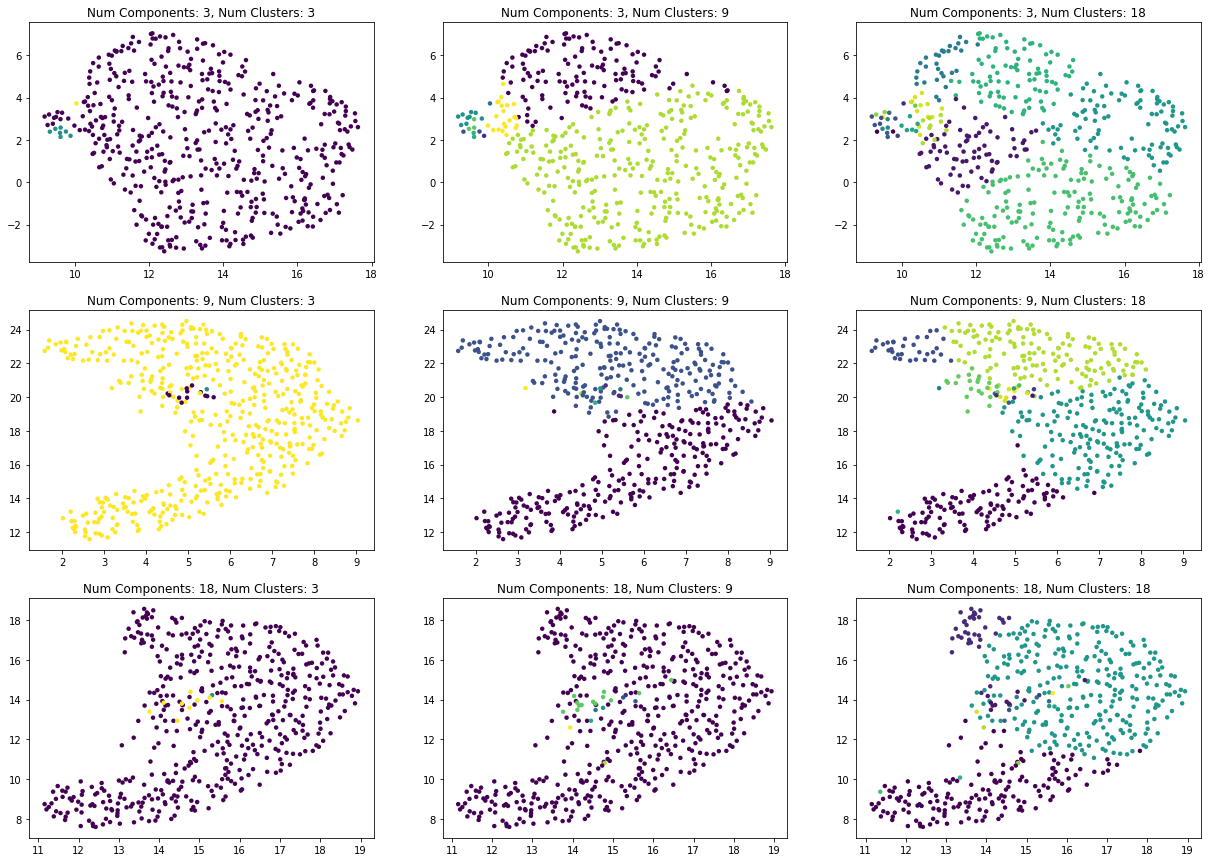

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import umap

fig, plts = plt.subplots(nrows=3, ncols=3, figsize=(21,15))
flat_plts = [item for sublist in plts for item in sublist]

# n components and n cluster combos
combos = [(num_components, num_clusters) for num_components in [3, 9, 18] for num_clusters in [3, 9, 18]]

for idx in range(len(combos)):
    num_components = combos[idx][0]
    num_clusters = combos[idx][1]

    U, Sigma, VT = randomized_svd(tfidf_matrix, 
                                n_components=num_components,
                                n_iter=100,
                                random_state=42)

    km = KMeans(n_clusters=num_clusters)
    document_embeddings = U * Sigma
    km.fit(document_embeddings)
    clusters = km.labels_.tolist()

    embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=42).fit_transform(document_embeddings)

    flat_plts[idx].set_title(f"Num Components: {num_components}, Num Clusters: {num_clusters}")
    flat_plts[idx].scatter(embedding[:, 0], embedding[:, 1], c=clusters, s=20, edgecolor='none')

plt.show()

Anywhere beyond roughly 10 components for the SVD operation seems to result in document embeddings that cluster poorly. There also seems to be a set of documents that lie close to the centre of the document embedding space that are different enough from the other documents that they get delineatated in clusters first, before increasing the number of clusters allows other documents outside that small set to be delineatated in clusters too, as seen when the number of clusters is 18.

## Problem 2.5 Latent Dirichlet Allocation

Run LDA on `documents` using `sklearn` (find the documentation at this [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation))

Make sure to specify `random_state=42` for replicability. 

What are the topics allocated to each word of document number 13? 

In [14]:
print(documents[13])

['Philadelphia', ',', 'Jan.', '23', '--', 'Nick', ...]


In [60]:
# Write your code here.
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=12, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=12, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [61]:
# create tfidf where each word in document number 13 is a 'document'
doc13_docs = [[word] for word in documents[13]]
doc13_tfidf, doc13_vocab = create_tfidf_matrix(doc13_docs)
doc13_tfidf_remapped = remap_vocab(doc13_tfidf, doc13_vocab, vocabulary)
doc13_topic_scores = lda.transform(doc13_tfidf_remapped)
doc13_topics = doc13_topic_scores.argmax(axis=1)

n_top_words = 5
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [vocabulary[i] for i in top_features_ind]
    print(f"Topic {topic_idx + 1}: {' '.join(top_features)}")

print('')

for idx in range(len(documents[13])):
    if np.sum(doc13_tfidf[idx, :]) > 0:
        print(f"Word: {documents[13][idx]}, Topic: {doc13_topics[idx] + 1}")


Topic 1: af church president state school
Topic 2: af mercer questionnaire petitioner coating
Topic 3: phil hanover winston tilghman hoag
Topic 4: matsuo kate bronchial palfrey artery
Topic 5: stress allotment ramey shayne rector
Topic 6: af anode hearst polynomial wage
Topic 7: shelter wine alfred wines madden
Topic 8: dictionary scotty brannon index helva
Topic 9: af ekstrohm maris onset mantle
Topic 10: miriam wright cattle andy coolidge
Topic 11: fiscal carleton barton linda bobbie
Topic 12: binomial feed skywave af lucy

Word: Philadelphia, Topic: 1
Word: 23, Topic: 1
Word: Nick, Topic: 10
Word: Skorich, Topic: 8
Word: line, Topic: 1
Word: coach, Topic: 3
Word: football, Topic: 1
Word: champion, Topic: 1
Word: Philadelphia, Topic: 1
Word: Eagles, Topic: 8
Word: elevated, Topic: 1
Word: today, Topic: 1
Word: head, Topic: 1
Word: coach, Topic: 3
Word: Skorich, Topic: 8
Word: received, Topic: 1
Word: contract, Topic: 1
Word: salary, Topic: 1
Word: believed, Topic: 1
Word: year, Topic